In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from auto_deploy.predictor import Predictor
import os
import json
import cv2
import numpy as np
import pickle
import ipdb
import time

In [2]:
pkl_path = "/home/liliang/map_result.pkl"
result_path = "/home/liliang/.benchmark/map_result.json"
# map_f = open(result_path, "r")
# label_info_save = {}
# for line in map_f:
#     obj = json.loads(line)
#     label = obj["label"]
#     path = obj["path"]
#     _id = obj["_id"]
#     ret = obj["result"]
#     bbox = obj["bbox"]
#     ap = obj["ap"]
#     q_failed = obj["q_failed"]
#     if not label in label_info_save:
#         label_info_save[label] = {_id:[ret, path, bbox, ap, q_failed]}
#     else:
#         label_info_save[label].update({_id:[ret, path, bbox, ap, q_failed]})
# with open(pkl_path, "wb") as f:
#     pickle.dump(label_info_save, f)
with open(pkl_path, "rb") as f:
    label_info = pickle.load(f)
total_imgs = sum([len(label_info[i]) for i in label_info.keys()])
print("labels: %s, imgs: %s"%(len(label_info.keys()), total_imgs))

labels: 969, imgs: 44393


5d2c82b5d3a3df19dc8645c4
5d2c82f3d3a3df19dc864acb
5d2c836bd3a3df19dc8654f1
5d2c8370d3a3df19dc865582
5d2c8374d3a3df19dc8655b0
5d2c8378d3a3df19dc86561e
5d2c8378d3a3df19dc86562c
5d2c8378d3a3df19dc865669
5d2c837cd3a3df19dc8656ba
5d2c83d8d3a3df19dc865e5b
5d2c842ed3a3df19dc866544
5d2c8434d3a3df19dc866597
5d2c84b0d3a3df19dc867103
5d2c84d3d3a3df19dc867435
5d2c84dbd3a3df19dc8674a2
5d2c84ecd3a3df19dc867627
5d2c87ebd3a3df19dc86bcd8


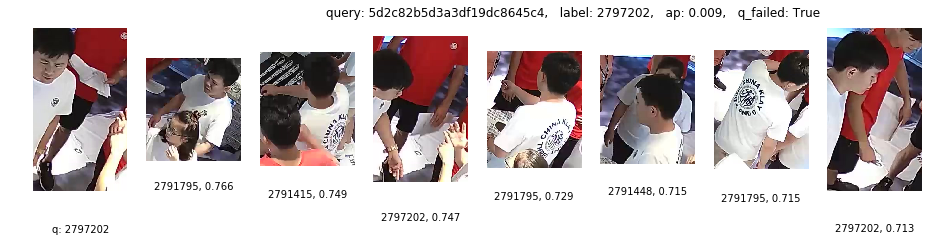

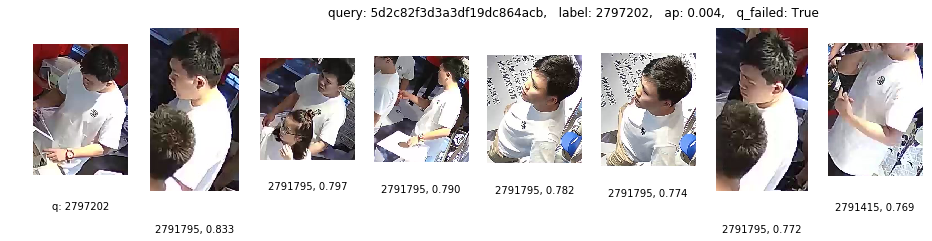

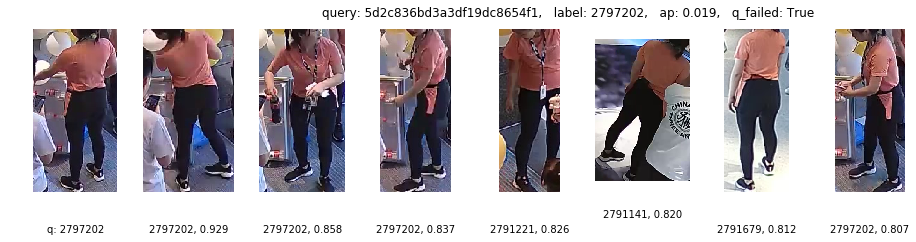

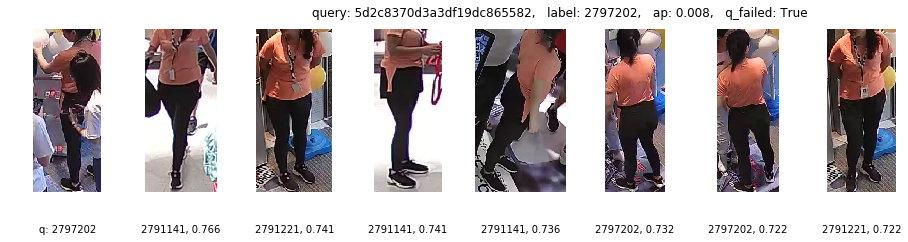

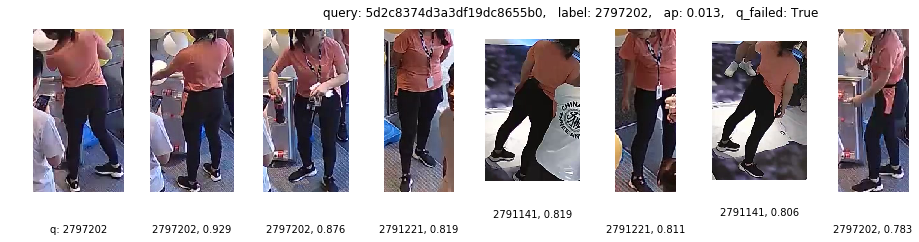

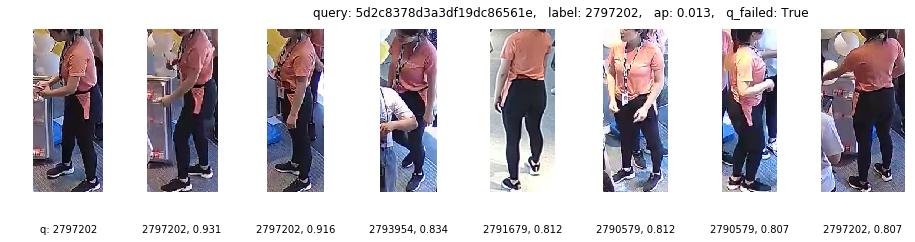

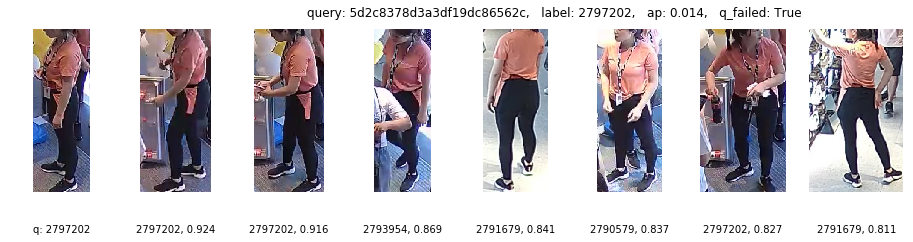

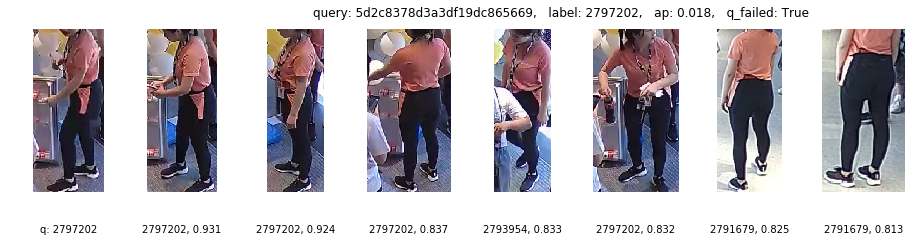

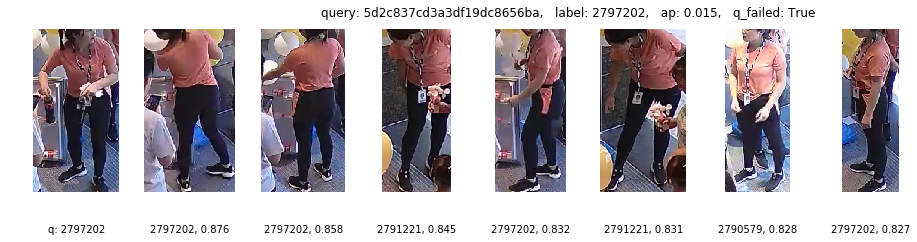

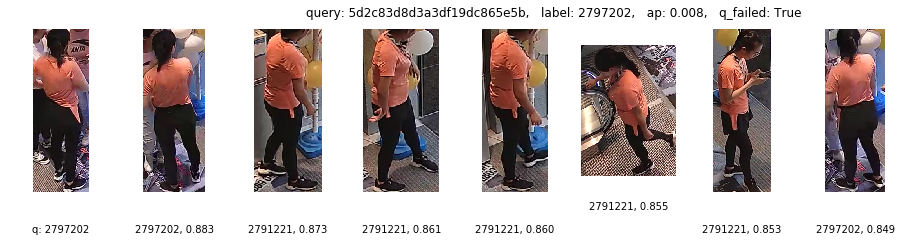

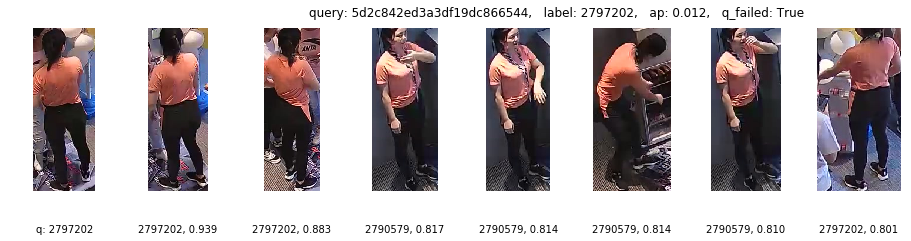

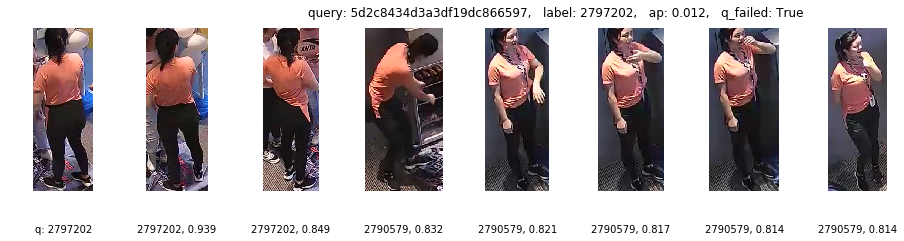

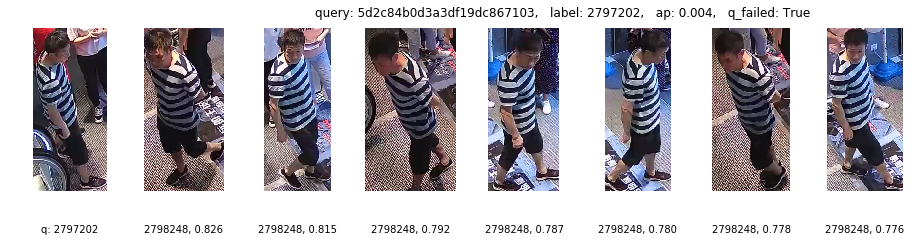

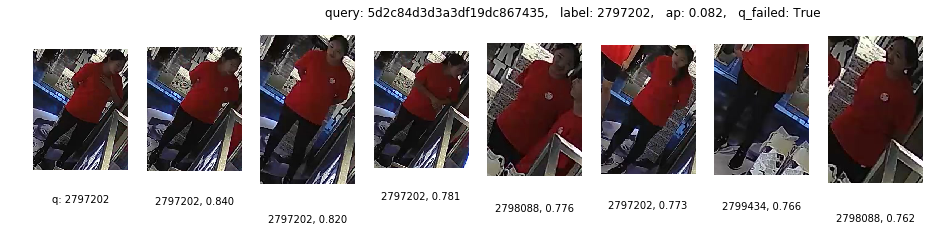

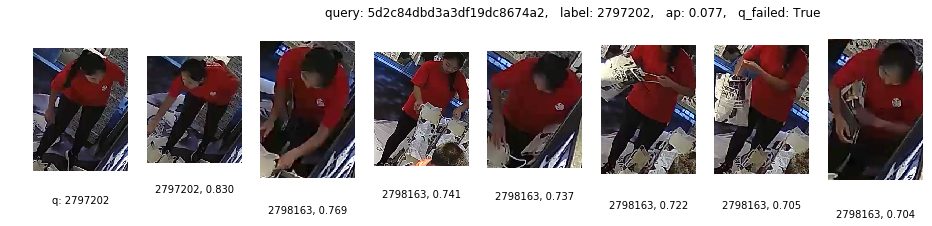

In [6]:
max_q_labels = 900
max_q_id = 1000
max_q_prob = 7
max_draw = 50

rdn_labels = np.random.choice(list(label_info.keys()), size=max_q_labels, replace=False)
rdn_labels = [2797202]
idx=0
for label in rdn_labels:
    if idx>max_draw:
        break
    for i, id_info in enumerate(list(label_info[label].items())[:max_q_id]):
        _id, query_rets = id_info
        rets, path, bbox, ap, q_failed = query_rets
        
        if q_failed:
            plt.figure(idx, figsize=(20, 3))
            idx+=1
            plt.suptitle("query: " + _id + \
                         ",   label: " + str(label) +
                         ",   ap: " + str(ap)[:5] +
                         ",   q_failed: " + str(q_failed),
                         horizontalalignment='center')
            n_topk = len(rets)
            
            plt.subplot(1, n_topk, 1)
            img = cv2.imread(path)
            xs, ys = zip(*bbox)
            xmin, ymin = min(xs), min(ys)
            xmax, ymax = max(xs), max(ys)
            h, w = img.shape[:2]
            xmin *= w
            xmax *= w
            ymin *= h
            ymax *= h
            img = img[int(ymin):int(ymax), int(xmin):int(xmax)]
            img = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)
            plt.imshow(img)
            plt.text(img.shape[1]/2, img.shape[0]*1.2, "q: %s"%str(label), verticalalignment="top", horizontalalignment="center")
            plt.axis('off')
            print(_id)
            
            for k, ret in enumerate(rets[:max_q_prob]):
                k_dist, k_id, k_label = ret
                k_path, k_bbox  = label_info[k_label][k_id][1:3]
                plt.subplot(1, n_topk, k+2)
                img = cv2.imread(k_path)
                xs, ys = zip(*k_bbox)
                xmin, ymin = min(xs), min(ys)
                xmax, ymax = max(xs), max(ys)
                h, w = img.shape[:2]
                xmin *= w
                xmax *= w
                ymin *= h
                ymax *= h
                img = img[int(ymin):int(ymax), int(xmin):int(xmax)]
                img = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)
#                 img = cv2.resize(img, (128, 256),
#                              interpolation=cv2.INTER_CUBIC)
                plt.imshow(img)
                plt.text(img.shape[1]/2, img.shape[0]*1.2, "%s, %.3f"%(k_label, k_dist) , verticalalignment="top", horizontalalignment="center")
                plt.axis('off')
        

## cal_imgpair_distance

In [12]:
from auto_deploy.predictor import Predictor
import torch
import numpy as np

def _img_crop(path, bbox):
    img = cv2.imread(path)
    xs, ys = zip(*bbox)
    xmin, ymin = min(xs), min(ys)
    xmax, ymax = max(xs), max(ys)
    h, w = img.shape[:2]
    xmin *= w
    xmax *= w
    ymin *= h
    ymax *= h
    img = img[int(ymin):int(ymax), int(xmin):int(xmax)]
    return img

def _cosine_dist(x, y):
    x = torch.from_numpy(x)
    y = torch.from_numpy(y)
    x_norm = torch.norm(x, p=2)
    y_norm = torch.norm(y, p=2)
    dot = torch.matmul(x, y)
    distances = dot.div_(torch.matmul(x_norm,
                                      y_norm.reshape(1, -1)).add_(1e-8))
    return distances

def _cosine_distance(vec1, vec2):
    vec1_norm = np.linalg.norm(vec1)
    vec2_norm = np.linalg.norm(vec2)
    return vec1.dot(vec2) / (vec1_norm * vec2_norm)

model_path= "/world/data-c7/liliang/pytorch_reid_models/resnet_50_ibn_a_20190805_153839.pt"
preprocess_dict = {"norm_lambda": "lambda x: x", "color_mode": "RGB"}
input_size = (128, 256)
predictor = Predictor(gpu=0, input_size=input_size, model_path=model_path, preprocess_dict=preprocess_dict)

img_list = []
label = 2797202
_id = "5d2c84b0d3a3df19dc867103"
topk_ret = 0
ret_dist, ret_id, ret_label = label_info[label][_id][0][topk_ret]

img_list.append(label_info[label][_id])
img_list.append(label_info[ret_label][ret_id])

ft_list = []
for img in img_list:
    path, bbox = img[1:3]
    img = _img_crop(path, bbox)
    ft = predictor.predict([img])[0][0]
    ft = np.array(ft)
    ft_list.append(ft)


dist = _cosine_distance(ft_list[0], ft_list[1])
print("ori dist:%s"% ret_dist)
print("label:%s  _id:%s  "%(label, _id))
print("label:%s  _id:%s  "%(ret_label, ret_id))
print("dist: %s"%dist)

ori dist:0.8263759016990662
label:2797202  _id:5d2c84b0d3a3df19dc867103  
label:2798248  _id:5d2c8434d3a3df19dc8665c0  
dist: 0.8263759396013755
